<a href="https://colab.research.google.com/github/matin/garth/blob/main/colabs/stress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Garmin stress trends using [Garth](https://github.com/matin/garth) and Matplotlib

## Setup

Start by installing and importing Garth

In [1]:
%pip install garth >& /dev/null

In [2]:
import garth

Define Garth access token location to save and resume sessions

In [3]:
GARTH_HOME = "drive/MyDrive/garth"

Mount Drive for saving and resuming sessions

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Attemt to resume session. If resuming the session fails or the path set for `GARTH_HOME` doesn't exist, log in. In both cases, save the new / updated session for future use.

In [5]:
from garth.exc import GarthException
from getpass import getpass

try:
    garth.resume(GARTH_HOME)
    garth.client.username
except (FileNotFoundError, GarthException):
    email = input("Email: ")
    password = getpass("Password: ")
    garth.client.login(email, password)

garth.save(GARTH_HOME)

## Weekly stress

Get the most recent week.

In [6]:
garth.WeeklyStress.list()[0]

WeeklyStress(calendar_date=datetime.date(2023, 9, 26), value=28)

Get the last two years.

In [7]:
weekly_stress = garth.WeeklyStress.list(period=104)

Use Pandas and Matplotlib with Seaborn styling to graph

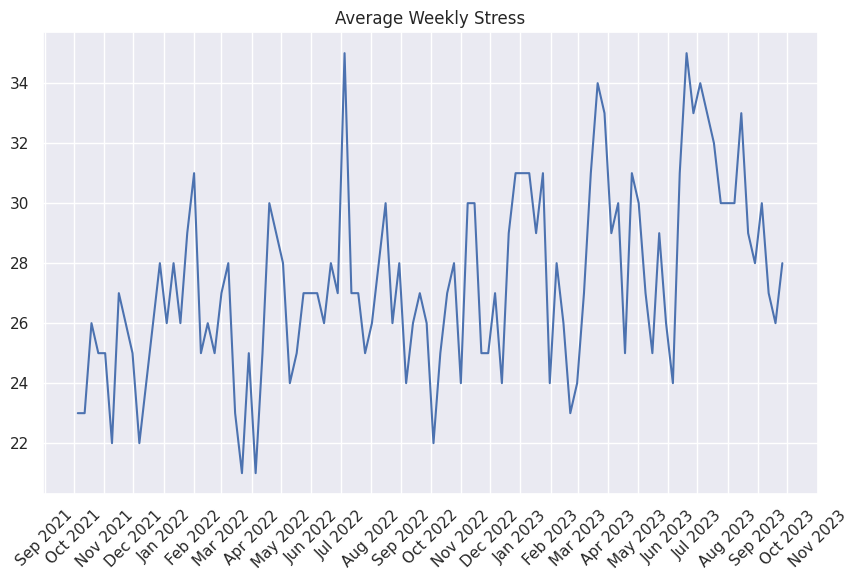

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import pyplot as plt

df = pd.DataFrame(weekly_stress).sort_values("calendar_date")

sns.set_theme()

plt.figure(figsize=(10, 6))

sns.lineplot(x=df["calendar_date"], y=df["value"])

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

plt.xticks(rotation=45)

plt.xlabel(None)
plt.ylabel(None)
plt.title("Average Weekly Stress")

plt.show()

## Daily stress trends

Retrieve daily averages by week. This takes a while to run.


Get yesterday's stress levels.

In [9]:
from datetime import date, timedelta

garth.DailyStress.list(date.today() - timedelta(days=1))[0]

DailyStress(calendar_date=datetime.date(2023, 10, 1), overall_stress_level=30, rest_stress_duration=36900, low_stress_duration=8640, medium_stress_duration=7680, high_stress_duration=4140)

Get up to the last three years.

In [10]:
daily_stress = garth.DailyStress.list(period=365 * 3)

Daily stats are going to have a *lot* of noise, so let's also graph the 28-day rolling average.

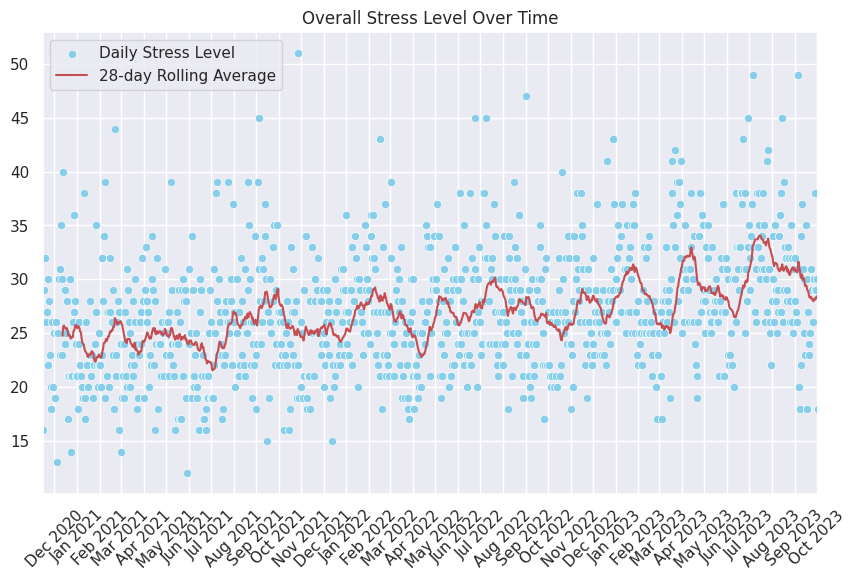

In [11]:
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import pyplot as plt

sns.set_theme()

df = pd.DataFrame(daily_stress)
df.set_index("calendar_date", inplace=True)

df["rolling_avg"] = df["overall_stress_level"].rolling(window=28).mean()

plt.figure(figsize=(10, 6))

sns.scatterplot(
    x=df.index,
    y=df["overall_stress_level"],
    color="skyblue",
    label="Daily Stress Level"
)

sns.lineplot(
    x=df.index,
    y=df["rolling_avg"],
    color="r",
    label="28-day Rolling Average"
)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

plt.xticks(rotation=45)
plt.xlim(df.index.min(), df.index.max())
plt.xlabel(None)
plt.ylabel(None)
plt.title("Overall Stress Level Over Time")
plt.legend()

plt.show()

We can also use `seasonal_decompose` to look at the 28-day trend.

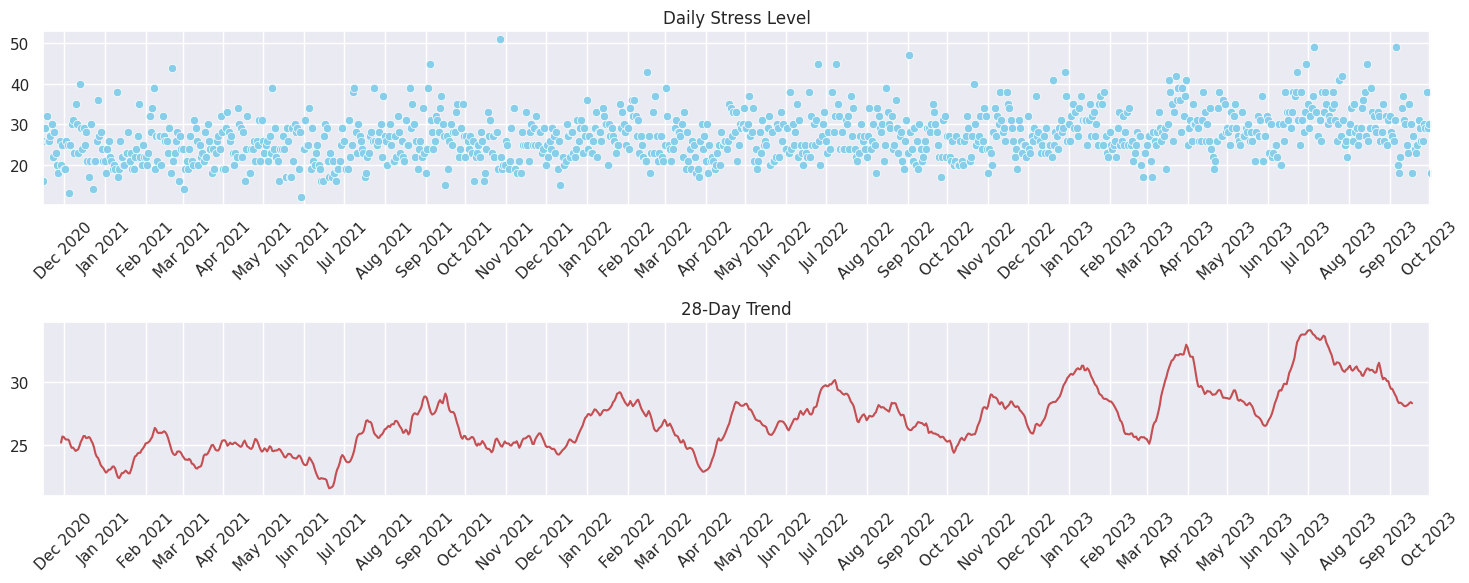

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(
    df["overall_stress_level"], model="additive", period=28
)
trend = result.trend.dropna()

min_date = df.index.min()
max_date = df.index.max()

def plot_subplot(ax, x, y, title, color, plot_type="line"):
    if plot_type == "line":
        sns.lineplot(ax=ax, x=x, y=y, color=color)
    elif plot_type == 'scatter':
        sns.scatterplot(ax=ax, x=x, y=y, color=color)

    ax.set_title(title)
    ax.set_xlim(min_date, max_date)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    ax.tick_params(axis="x", rotation=45)

fig, axes = plt.subplots(2, 1, figsize=(15, 6))

plot_subplot(
    axes[0], df.index, df["overall_stress_level"],
    "Daily Stress Level", "skyblue", plot_type='scatter'
)
plot_subplot(axes[1], trend.index, trend, "28-Day Trend", "r")

plt.tight_layout()
plt.show()
